# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [3]:
train_npz = np.load('./data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('./data/test_input.npz')
test_data  = test_npz['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [4]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

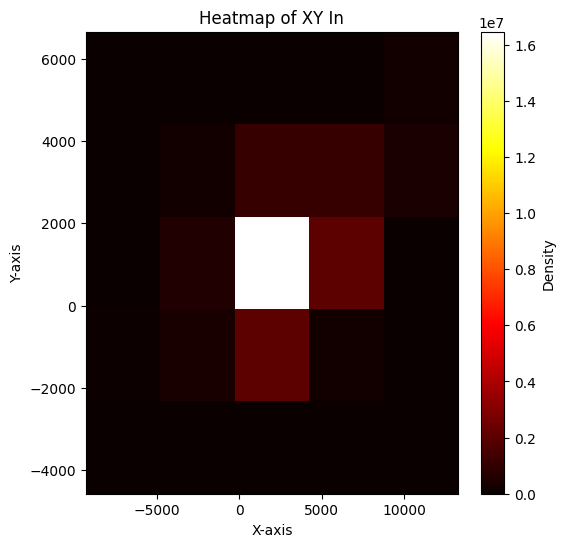

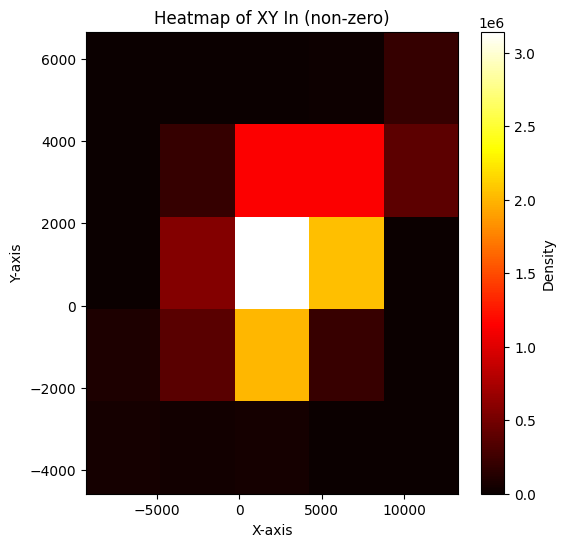

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

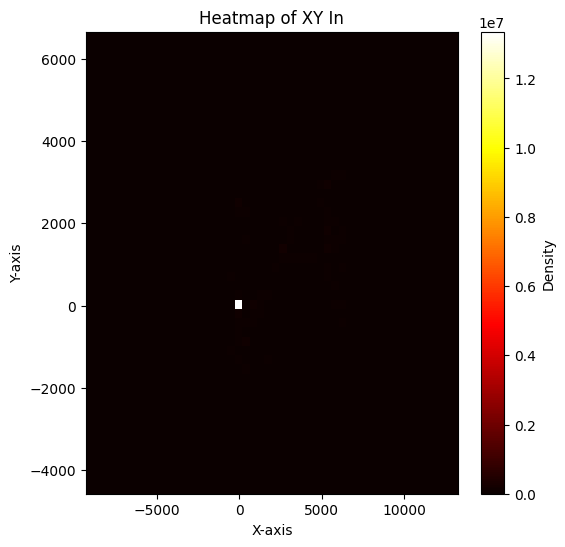

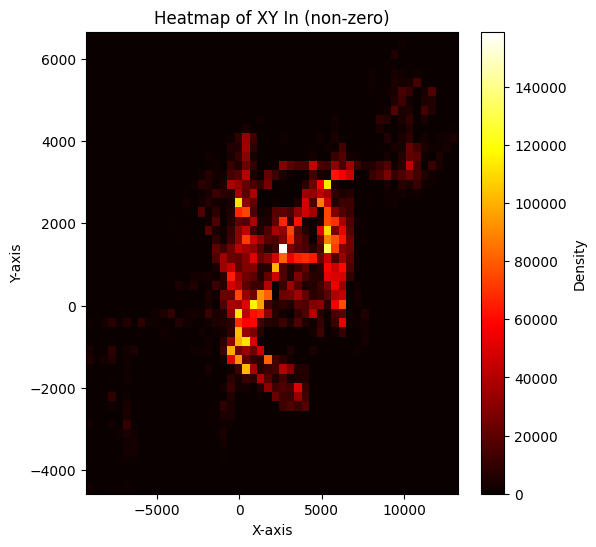

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

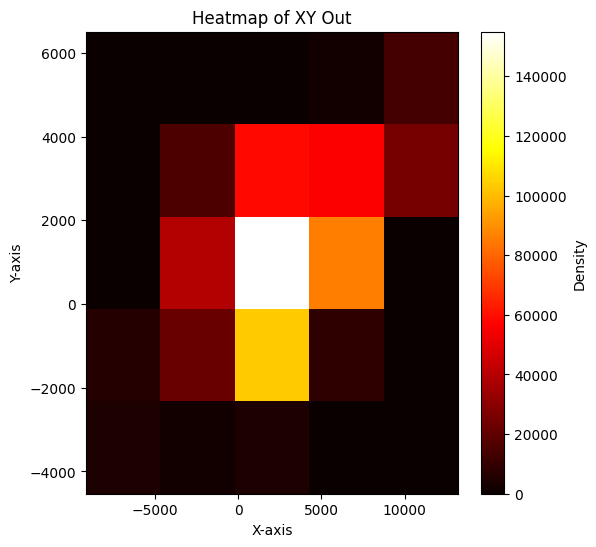

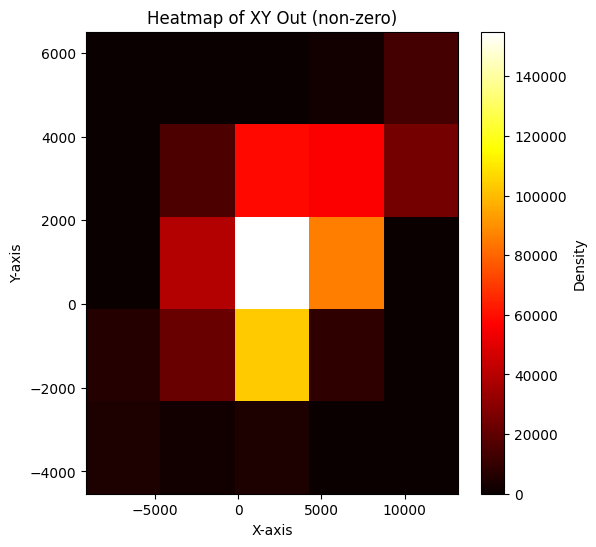

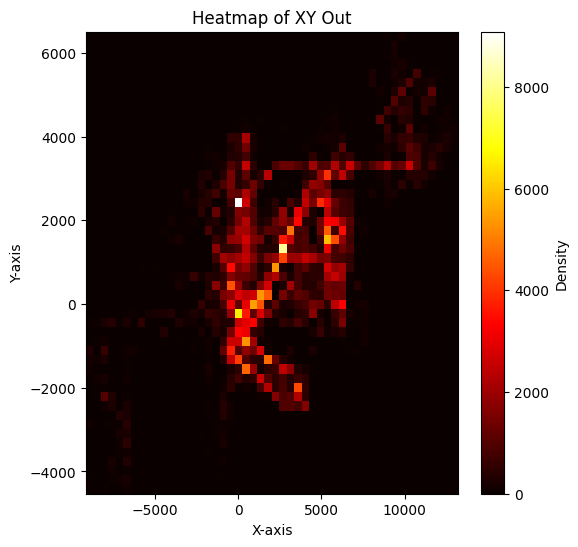

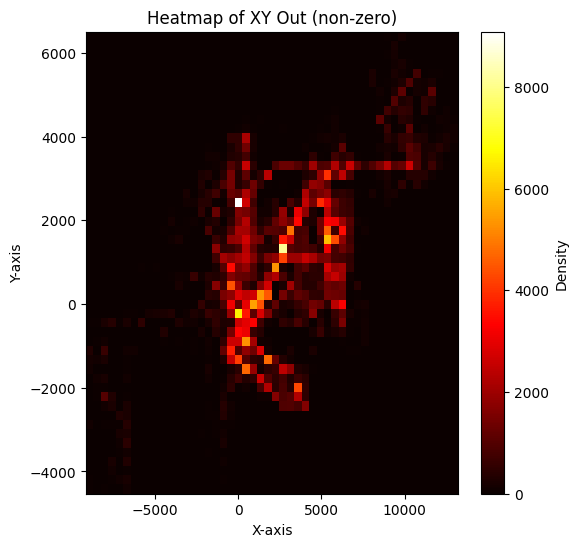

In [21]:
xy_out = train_data[:, 0, 50:, :2].reshape(-1, 2)
xy_out_not_0 = xy_out[(xy_out[:, 0] != 0) & (xy_out[:, 1] != 0)]
plot_heatmap(xy_out, title='Heatmap of XY Out', bins=5)
plot_heatmap(xy_out_not_0, title='Heatmap of XY Out (non-zero)', bins=5)
plot_heatmap(xy_out, title='Heatmap of XY Out', bins=50)
plot_heatmap(xy_out_not_0, title='Heatmap of XY Out (non-zero)', bins=50)

## Step 3: Setting up the Training and Testing

### Example Code:

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))


# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        # x = x[:, :, :, :6] # (batch, 50, 50, 6)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [ ]:
class CNN(nn.Module):
    def __init__(self, 
                 input_channels=6, 
                 output_channels=2,
                 num_conv_blocks=3,
                 num_fc_blocks=2,
                 max_pooling=True):
        super(CNN, self).__init__()
        
        # Define the layers
        layers = []
        layers.append(nn.Conv2d(input_channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        n_filters = 64
        w, h = 50, 50
        for _ in range(num_conv_blocks - 2):
            layers.append(nn.Conv2d(n_filters, n_filters * 2, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            n_filters *= 2
            if max_pooling:
                layers.append(nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)))
                w, h = w, h // 2

        layers.append(nn.Conv2d(n_filters, output_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())

        # Flatten the output
        layers.append(nn.Flatten())

        # Fully connected layers
        hidden_size = w * h * output_channels
        for _ in range(num_fc_blocks):
            layers.append(nn.Linear(hidden_size, hidden_size // 2))
            layers.append(nn.ReLU())
            hidden_size //= 2
        layers.append(nn.Linear(hidden_size, 60 * 2))
        self.model = nn.Sequential(*layers)


    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6) # (batch, 50, 50, 6)
        x = x.permute(0, 3, 1, 2)
        x = self.model(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [7]:
from torch import nn
import torch

class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2, num_layers=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [26]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = CNN(input_channels=6,
#                     output_channels=2,
#                     num_conv_blocks=2,
#                     num_fc_blocks=2,
#                     max_pooling=False
#                    ).to(device)
model = LSTM(hidden_dim=256, num_layers=1).to(device)

LR = 0.006828321444529112
DECAY = 0.00824308842435656
# DECAY = 0
total_steps = 50 * len(train_dataloader)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=DECAY)
# optimizer = optim.RMSprop(model.parameters(), lr=LR, weight_decay=DECAY)
# optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=DECAY)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LR,
        total_steps=total_steps,
        cycle_momentum=False
    )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_42858/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_42858/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   2%|▏         | 1/50 [00:05<04:42,  5.77s/epoch]

Epoch 000 | Learning rate 0.000273 | train normalized MSE   2.8205 | val normalized MSE   1.0928, | val MAE   4.3154 | val MSE  53.5487


Epoch:   4%|▍         | 2/50 [00:11<04:22,  5.46s/epoch]

Epoch 001 | Learning rate 0.000273 | train normalized MSE   0.7744 | val normalized MSE   0.5779, | val MAE   2.9744 | val MSE  28.3165


Epoch:   6%|▌         | 3/50 [00:15<04:02,  5.16s/epoch]

Epoch 002 | Learning rate 0.000273 | train normalized MSE   0.5319 | val normalized MSE   0.4869, | val MAE   2.6678 | val MSE  23.8579


Epoch:   8%|▊         | 4/50 [00:20<03:51,  5.02s/epoch]

Epoch 003 | Learning rate 0.000273 | train normalized MSE   0.4597 | val normalized MSE   0.4085, | val MAE   2.3802 | val MSE  20.0152


Epoch:  10%|█         | 5/50 [00:25<03:39,  4.89s/epoch]

Epoch 004 | Learning rate 0.000273 | train normalized MSE   0.4233 | val normalized MSE   0.3957, | val MAE   2.3438 | val MSE  19.3871


Epoch:  12%|█▏        | 6/50 [00:29<03:29,  4.76s/epoch]

Epoch 005 | Learning rate 0.000273 | train normalized MSE   0.4010 | val normalized MSE   0.3696, | val MAE   2.2281 | val MSE  18.1084


Epoch:  14%|█▍        | 7/50 [00:34<03:22,  4.70s/epoch]

Epoch 006 | Learning rate 0.000273 | train normalized MSE   0.3822 | val normalized MSE   0.3841, | val MAE   2.2826 | val MSE  18.8191


Epoch:  16%|█▌        | 8/50 [00:38<03:15,  4.65s/epoch]

Epoch 007 | Learning rate 0.000273 | train normalized MSE   0.3586 | val normalized MSE   0.3470, | val MAE   2.1107 | val MSE  17.0053


Epoch:  18%|█▊        | 9/50 [00:43<03:12,  4.71s/epoch]

Epoch 008 | Learning rate 0.000273 | train normalized MSE   0.3360 | val normalized MSE   0.3308, | val MAE   2.1549 | val MSE  16.2086


Epoch:  20%|██        | 10/50 [00:48<03:07,  4.70s/epoch]

Epoch 009 | Learning rate 0.000273 | train normalized MSE   0.3206 | val normalized MSE   0.3051, | val MAE   1.9835 | val MSE  14.9515


Epoch:  22%|██▏       | 11/50 [00:53<03:05,  4.76s/epoch]

Epoch 010 | Learning rate 0.000273 | train normalized MSE   0.3171 | val normalized MSE   0.2929, | val MAE   1.8998 | val MSE  14.3497


Epoch:  24%|██▍       | 12/50 [00:58<03:03,  4.82s/epoch]

Epoch 011 | Learning rate 0.000273 | train normalized MSE   0.3003 | val normalized MSE   0.2907, | val MAE   1.9026 | val MSE  14.2426


Epoch:  26%|██▌       | 13/50 [01:03<02:58,  4.82s/epoch]

Epoch 012 | Learning rate 0.000273 | train normalized MSE   0.2995 | val normalized MSE   0.2760, | val MAE   1.9375 | val MSE  13.5223


Epoch:  28%|██▊       | 14/50 [01:07<02:54,  4.84s/epoch]

Epoch 013 | Learning rate 0.000273 | train normalized MSE   0.2924 | val normalized MSE   0.2822, | val MAE   1.9786 | val MSE  13.8284


Epoch:  30%|███       | 15/50 [01:12<02:47,  4.80s/epoch]

Epoch 014 | Learning rate 0.000273 | train normalized MSE   0.2796 | val normalized MSE   0.2719, | val MAE   1.8480 | val MSE  13.3242


Epoch:  32%|███▏      | 16/50 [01:17<02:42,  4.77s/epoch]

Epoch 015 | Learning rate 0.000273 | train normalized MSE   0.2779 | val normalized MSE   0.2477, | val MAE   1.6673 | val MSE  12.1367


Epoch:  34%|███▍      | 17/50 [01:22<02:38,  4.81s/epoch]

Epoch 016 | Learning rate 0.000273 | train normalized MSE   0.2734 | val normalized MSE   0.2868, | val MAE   1.9923 | val MSE  14.0525


Epoch:  36%|███▌      | 18/50 [01:27<02:33,  4.81s/epoch]

Epoch 017 | Learning rate 0.000273 | train normalized MSE   0.2711 | val normalized MSE   0.2459, | val MAE   1.7173 | val MSE  12.0484


Epoch:  38%|███▊      | 19/50 [01:32<02:30,  4.84s/epoch]

Epoch 018 | Learning rate 0.000273 | train normalized MSE   0.2665 | val normalized MSE   0.2640, | val MAE   1.9268 | val MSE  12.9363


Epoch:  40%|████      | 20/50 [01:36<02:25,  4.86s/epoch]

Epoch 019 | Learning rate 0.000273 | train normalized MSE   0.2654 | val normalized MSE   0.2578, | val MAE   1.8062 | val MSE  12.6337


Epoch:  42%|████▏     | 21/50 [01:41<02:20,  4.84s/epoch]

Epoch 020 | Learning rate 0.000273 | train normalized MSE   0.2517 | val normalized MSE   0.2438, | val MAE   1.7190 | val MSE  11.9475


Epoch:  44%|████▍     | 22/50 [01:46<02:15,  4.85s/epoch]

Epoch 021 | Learning rate 0.000273 | train normalized MSE   0.2515 | val normalized MSE   0.2417, | val MAE   1.7659 | val MSE  11.8444


Epoch:  46%|████▌     | 23/50 [01:51<02:12,  4.91s/epoch]

Epoch 022 | Learning rate 0.000273 | train normalized MSE   0.2487 | val normalized MSE   0.2376, | val MAE   1.6721 | val MSE  11.6411


Epoch:  48%|████▊     | 24/50 [01:57<02:12,  5.10s/epoch]

Epoch 023 | Learning rate 0.000273 | train normalized MSE   0.2463 | val normalized MSE   0.2497, | val MAE   1.8067 | val MSE  12.2338


Epoch:  50%|█████     | 25/50 [02:02<02:12,  5.29s/epoch]

Epoch 024 | Learning rate 0.000273 | train normalized MSE   0.2413 | val normalized MSE   0.2274, | val MAE   1.6382 | val MSE  11.1423


Epoch:  52%|█████▏    | 26/50 [02:08<02:06,  5.29s/epoch]

Epoch 025 | Learning rate 0.000273 | train normalized MSE   0.2439 | val normalized MSE   0.2290, | val MAE   1.6906 | val MSE  11.2221


Epoch:  54%|█████▍    | 27/50 [02:13<02:01,  5.27s/epoch]

Epoch 026 | Learning rate 0.000273 | train normalized MSE   0.2382 | val normalized MSE   0.2341, | val MAE   1.7299 | val MSE  11.4704


Epoch:  56%|█████▌    | 28/50 [02:18<01:54,  5.22s/epoch]

Epoch 027 | Learning rate 0.000273 | train normalized MSE   0.2363 | val normalized MSE   0.2208, | val MAE   1.6859 | val MSE  10.8171


Epoch:  58%|█████▊    | 29/50 [02:23<01:47,  5.13s/epoch]

Epoch 028 | Learning rate 0.000273 | train normalized MSE   0.2334 | val normalized MSE   0.2388, | val MAE   1.7873 | val MSE  11.7031


Epoch:  60%|██████    | 30/50 [02:28<01:40,  5.04s/epoch]

Epoch 029 | Learning rate 0.000273 | train normalized MSE   0.2292 | val normalized MSE   0.2145, | val MAE   1.5996 | val MSE  10.5103


Epoch:  62%|██████▏   | 31/50 [02:33<01:35,  5.02s/epoch]

Epoch 030 | Learning rate 0.000273 | train normalized MSE   0.2272 | val normalized MSE   0.2197, | val MAE   1.5848 | val MSE  10.7647


Epoch:  64%|██████▍   | 32/50 [02:38<01:29,  4.98s/epoch]

Epoch 031 | Learning rate 0.000273 | train normalized MSE   0.2249 | val normalized MSE   0.2252, | val MAE   1.6882 | val MSE  11.0357


Epoch:  66%|██████▌   | 33/50 [02:43<01:26,  5.07s/epoch]

Epoch 032 | Learning rate 0.000273 | train normalized MSE   0.2228 | val normalized MSE   0.2164, | val MAE   1.6196 | val MSE  10.6031


Epoch:  68%|██████▊   | 34/50 [02:48<01:21,  5.11s/epoch]

Epoch 033 | Learning rate 0.000273 | train normalized MSE   0.2241 | val normalized MSE   0.2148, | val MAE   1.5477 | val MSE  10.5251


Epoch:  70%|███████   | 35/50 [02:53<01:15,  5.01s/epoch]

Epoch 034 | Learning rate 0.000273 | train normalized MSE   0.2251 | val normalized MSE   0.2069, | val MAE   1.5972 | val MSE  10.1372


Epoch:  72%|███████▏  | 36/50 [02:58<01:08,  4.92s/epoch]

Epoch 035 | Learning rate 0.000273 | train normalized MSE   0.2202 | val normalized MSE   0.2092, | val MAE   1.5810 | val MSE  10.2519


Epoch:  74%|███████▍  | 37/50 [03:03<01:05,  5.00s/epoch]

Epoch 036 | Learning rate 0.000273 | train normalized MSE   0.2176 | val normalized MSE   0.2244, | val MAE   1.6896 | val MSE  10.9965


Epoch:  76%|███████▌  | 38/50 [03:08<01:02,  5.19s/epoch]

Epoch 037 | Learning rate 0.000273 | train normalized MSE   0.2168 | val normalized MSE   0.2172, | val MAE   1.6065 | val MSE  10.6443


Epoch:  78%|███████▊  | 39/50 [03:14<00:56,  5.16s/epoch]

Epoch 038 | Learning rate 0.000273 | train normalized MSE   0.2163 | val normalized MSE   0.2113, | val MAE   1.6401 | val MSE  10.3561


Epoch:  80%|████████  | 40/50 [03:19<00:51,  5.11s/epoch]

Epoch 039 | Learning rate 0.000273 | train normalized MSE   0.2141 | val normalized MSE   0.2251, | val MAE   1.6474 | val MSE  11.0296


Epoch:  82%|████████▏ | 41/50 [03:23<00:45,  5.02s/epoch]

Epoch 040 | Learning rate 0.000273 | train normalized MSE   0.2128 | val normalized MSE   0.2147, | val MAE   1.6393 | val MSE  10.5189


Epoch:  84%|████████▍ | 42/50 [03:28<00:39,  4.94s/epoch]

Epoch 041 | Learning rate 0.000273 | train normalized MSE   0.2120 | val normalized MSE   0.2014, | val MAE   1.5474 | val MSE   9.8678


Epoch:  86%|████████▌ | 43/50 [03:33<00:34,  4.95s/epoch]

Epoch 042 | Learning rate 0.000273 | train normalized MSE   0.2110 | val normalized MSE   0.2046, | val MAE   1.5335 | val MSE  10.0275


Epoch:  88%|████████▊ | 44/50 [03:38<00:30,  5.04s/epoch]

Epoch 043 | Learning rate 0.000273 | train normalized MSE   0.2109 | val normalized MSE   0.2081, | val MAE   1.5671 | val MSE  10.1977


Epoch:  90%|█████████ | 45/50 [03:43<00:24,  4.93s/epoch]

Epoch 044 | Learning rate 0.000273 | train normalized MSE   0.2103 | val normalized MSE   0.2010, | val MAE   1.5402 | val MSE   9.8482


Epoch:  92%|█████████▏| 46/50 [03:47<00:19,  4.76s/epoch]

Epoch 045 | Learning rate 0.000273 | train normalized MSE   0.2095 | val normalized MSE   0.2025, | val MAE   1.5507 | val MSE   9.9243


Epoch:  94%|█████████▍| 47/50 [03:52<00:14,  4.70s/epoch]

Epoch 046 | Learning rate 0.000273 | train normalized MSE   0.2040 | val normalized MSE   0.2004, | val MAE   1.5403 | val MSE   9.8174


Epoch:  96%|█████████▌| 48/50 [03:56<00:09,  4.63s/epoch]

Epoch 047 | Learning rate 0.000273 | train normalized MSE   0.2063 | val normalized MSE   0.2031, | val MAE   1.5727 | val MSE   9.9501


Epoch:  98%|█████████▊| 49/50 [04:01<00:04,  4.63s/epoch]

Epoch 048 | Learning rate 0.000273 | train normalized MSE   0.2063 | val normalized MSE   0.2023, | val MAE   1.5441 | val MSE   9.9119


Epoch: 100%|██████████| 50/50 [04:05<00:00,  4.92s/epoch]

Epoch 049 | Learning rate 0.000273 | train normalized MSE   0.2055 | val normalized MSE   0.1927, | val MAE   1.5231 | val MSE   9.4413


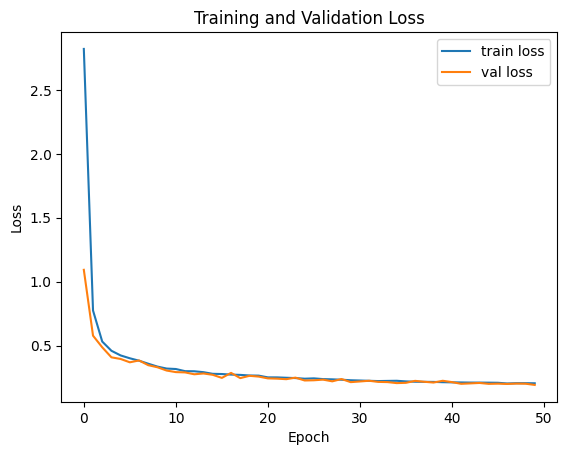

In [27]:
train_losses = []
val_losses = []
for epoch in tqdm.tqdm(range(50), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
      
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    # scheduler.step()
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

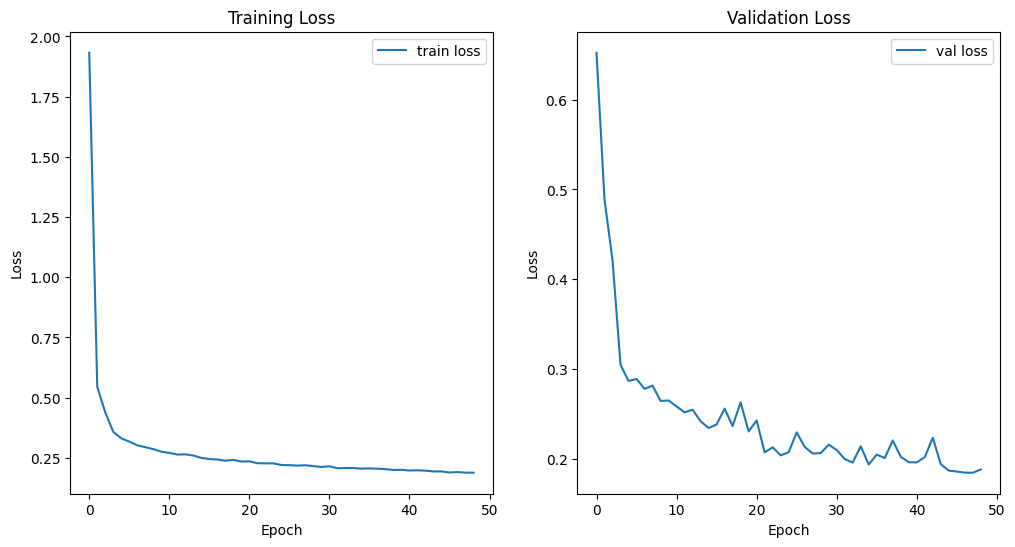

In [44]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_losses, label='train loss')    
ax[1].plot(val_losses, label='val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
# ax[0].set_ylim(0, 1000)
# ax[1].set_ylim(0, 1000)
ax[0].legend()
ax[1].legend()
plt.show()

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [45]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_17890/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


NameError: name 'plot_trajectory' is not defined

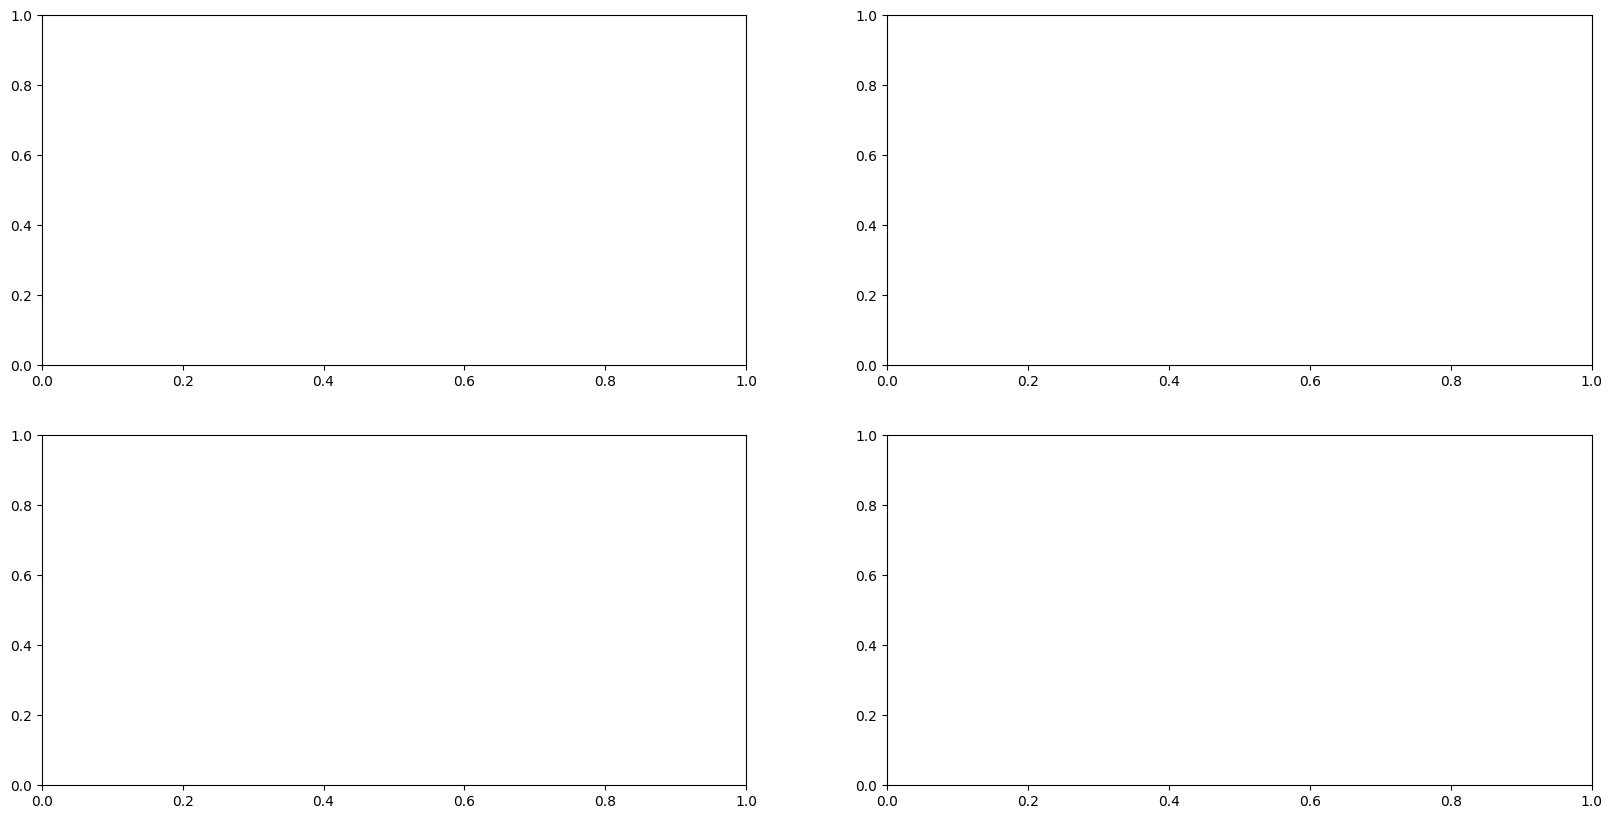

In [23]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [24]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

# best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

# model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B